<h1>Primo Progetto<h1>

In [15]:
# Importo le librerie richieste
import pandas as pd
from serpapi import GoogleScholarSearch
import json
import networkx as nx
import matplotlib.pyplot as plt
import os
from pyvis.network import Network

In [2]:
GoogleScholarSearch.SERP_API_KEY = "0abb32444148ee2f5264785a1516d02307eb96aac922da2b728ebafd3683d690"

# Punto 1)
A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per
ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autor

In [ ]:
# Importo il file nodes.csv
df = pd.read_csv('data/nodes.csv')
display(df)

In [ ]:

updated_df = pd.DataFrame(columns=['author_id', 'cited_by', 'interests'])

# Itero su ogni autore del dataframe
for index, row in df.iterrows():
    author_name = row['name']
    author_affliation = row['affiliations']
        
    params = {
        "engine" : "google_scholar_profiles",
        "hl": "en",
        "mauthors":f'{author_name},{author_affliation}'
    }
    search = GoogleScholarSearch(params)
    results = search.get_dict()['profiles']
    
    for profile in results:
        author_id = profile['author_id']
        cited_by = profile['cited_by']
        
        interests = []
        
        for interest in profile.get('interests', ):
            title = interest.get('title', '')
            interests.append(title)
    
    interests_str = ', '.join(interests)
    
    # Aggiungo una nuova riga al dataframe updated_df
    new_row = {'author_id': author_id, 'cited_by': cited_by, 'interests': interests_str}
    updated_df = pd.concat([updated_df, pd.DataFrame([new_row])], ignore_index=True)

new_df = pd.merge(df, updated_df, left_index=True, right_index=True)
display(new_df)



In [ ]:
# Sovrascrivo il file nodes.csv con le nuove informazioni trovate
new_df.to_csv('data/nodes.csv', index=False)

# Punto 2)
Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google Scholar e scaricare l’elenco dei suoi coautori, sempre via SerpAPI. <br> Con tale elenco di nomi:<br>
<br>
### Punto 2a)
+ Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a tale nome. Per ciascuno, salvare name, affiliations,
author_id, cited_by e interests in un nuovo DataFrame contenente tutte
queste informazioni relative ai coautori dei 7 autori originari.



In [ ]:
# Carica il file CSV aggiornato con gli ID degli autori
df = pd.read_csv('data/nodes.csv')

# Crea un DataFrame vuoto per i coautori
coauthors_df = pd.DataFrame(columns=['name', 'affiliations', 'author_id', 'cited_by', 'interests'])

# Itera su ogni autore
for index, row in df.iterrows():
    author_id = row['author_id']
    
    # Recupera il profilo dell'autore utilizzando l'ID
    author_params = {
        "engine": "google_scholar_author",
        "author_id": author_id,
        "hl": "en"
    }
    author_search = GoogleScholarSearch(author_params)
    author_profile = author_search.get_dict()

    # Elenca i coautori
    coauthors = author_profile.get('co_authors', [])

    # Per ogni coautore, esegui una ricerca separata includendo le affiliazioni
    for coauthor in coauthors:
        coauthor_name = coauthor['name']
        coauthor_affiliation = coauthor.get('affiliations', '')  # Se disponibile

        # Ricerca il profilo del coautore
        coauthor_params = {
            "engine": "google_scholar_profiles",
            "hl": "en",
            "mauthors": f"{coauthor_name} {coauthor_affiliation}"
        }
        coauthor_search = GoogleScholarSearch(coauthor_params)
        coauthor_results = coauthor_search.get_dict()['profiles'][0]  # Prende il primo profilo come corretto

        # Crea una riga con le informazioni del coautore
        new_row = pd.DataFrame([{
            'name': coauthor_results['name'],
            'affiliations': coauthor_results.get('affiliations', ''),
            'author_id': coauthor_results.get('author_id', ''),
            'cited_by': coauthor_results.get('cited_by', ''),
            'interests': ', '.join([interest['title'] for interest in coauthor_results.get('interests', [])])
        }])

        # Aggiunge la nuova riga al DataFrame
        coauthors_df = pd.concat([coauthors_df, new_row], ignore_index=True)

# Rimuove i doppioni e ordina per nome
coauthors_df.drop_duplicates(inplace=True)
coauthors_df.sort_values(by='name', inplace=True)

# Salva il DataFrame in un file CSV
coauthors_df.to_csv('data/coauthors.csv', index=False)

### Punto 2b)
+ Concatenare il DataFrame con i 7 autori originari e quello dei coautorigenerato al punto 2a in un unico DataFrame


In [ ]:
# Carica i DataFrame
df1 = pd.read_csv('data/nodes.csv')  # DataFrame degli autori originali
df2 = pd.read_csv('data/coauthors.csv')  # DataFrame dei coautori

# Concatena i DataFrame degli autori originali e dei coautori
combined_df = pd.concat([df1, df2], ignore_index=True)

# Ordina il DataFrame combinato per nome
combined_df.sort_values(by='name', inplace=True)

# Rimuovi eventuali duplicati basati sull'ID dell'autore (da provare anche senza "author_id")
combined_df.drop_duplicates(inplace=True) # combined_df.drop_duplicates(subset='author_id', inplace=True)

# Salva il DataFrame combinato in un file CSV
combined_df.to_csv('data/combined_authors.csv', index=False)

### Punto 2c)
+ Creare un terzo DataFrame con le colonne author1, author2 che
rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un arco di coauthorship tra due autori.


In [ ]:
# Carica il file nodes.csv aggiornato con name, affiliations,author_id, cited_by e interests dei 7 autori originali
df = pd.read_csv('data/nodes.csv')

# Inizializza un DataFrame vuoto per le relazioni di coautorialità
edges_df = pd.DataFrame(columns=['author1', 'author2'])

# Itera su ogni autore originale
for index, row in df.iterrows():
    author_name = row['name']
    author_id = row['author_id']

    # Recupera il profilo dell'autore utilizzando l'ID
    author_params = {
        "engine": "google_scholar_author",
        "author_id": author_id,
        "hl": "en"
    }
    author_search = GoogleScholarSearch(author_params)
    author_profile = author_search.get_dict()

    # Elenca i coautori
    coauthors = author_profile.get('co_authors', [])

    # Per ogni coautore
    for coauthor in coauthors:
        coauthor_name = coauthor['name']
        # Crea un nuovo DataFrame con la relazione di coautorialità
        new_row = pd.DataFrame([{'author1': author_name, 'author2': coauthor_name}])
        # Aggiungi la relazione di coautorialità al DataFrame edges_df utilizzando pd.concat
        edges_df = pd.concat([edges_df, new_row], ignore_index=True)

# Salva il DataFrame in un file CSV
edges_df.to_csv('data/edges.csv', index=False)

#### Aggiustamenti prima di procedere ai punti successivi
Sono stati eliminati dalla cartella 'data' i file nodes.csv e coauthors.csv in quanto non sono più utili ai fini del progetto. <br>
A differenza del file 'combined.csv' che è stato rinominato in 'nodes.csv', in modo da rispettare la struttura interna del progetto, e più in particolare della cartella 'data'. <br>
Inoltre, è stato ripulito il file 'edges.csv' in modo da non avere ripetizioni, intese come coppie simmetriche. Ad esempio, se è presente la coppia ('David La Barbera', 'Stefano Mizzaro'), allora sicuramente esisterà anche la simmetrica, per non avere questa ridondanza si è deciso di eliminare una delle due coppie in modo che il legame tra i due autori compaia una sola volta. <br>

In [ ]:
# Percorsi dei file
path_nodes = 'data/nodes.csv'
path_coauthors = 'data/coauthors.csv'
path_combined_authors = 'data/combined_authors.csv'
new_path_nodes = 'data/nodes.csv'

# Elimina nodes.csv e coauthors.csv se esistono
if os.path.exists(path_nodes):
    os.remove(path_nodes)

if os.path.exists(path_coauthors):
    os.remove(path_coauthors)

# Rinomina combined_authors.csv in nodes.csv
if os.path.exists(path_combined_authors):
    os.rename(path_combined_authors, new_path_nodes)

In [ ]:
# Carica il DataFrame edges
edges_df = pd.read_csv('data/edges.csv')

# Crea una colonna temporanea con set di autori
edges_df['author_pair'] = edges_df.apply(lambda row: frozenset([row['author1'], row['author2']]), axis=1)

# Rimuovi i duplicati basati sulla colonna dei set di autori
edges_df = edges_df.drop_duplicates(subset='author_pair')

# Elimina la colonna temporanea
edges_df = edges_df.drop('author_pair', axis=1)

# Salva il DataFrame aggiornato
edges_df.to_csv('data/edges_cleaned.csv', index=False)

In [ ]:
# Percorsi dei file
path_edges = 'data/edges.csv'
path_edges_cleaned = 'data/edges_cleaned.csv'

# Elimina edges.csv se esiste
if os.path.exists(path_edges):
    os.remove(path_edges)

# Rinomina edges_cleaned.csv in edges.csv
if os.path.exists(path_edges_cleaned):
    os.rename(path_edges_cleaned, path_edges)

# Punto 3)
Utilizzando i due DataFrame prodotti: <br>
<br>
### Punto 3a)
Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .

In [3]:
nodes = pd.read_csv('data/nodes.csv')
edges = pd.read_csv('data/edges.csv')

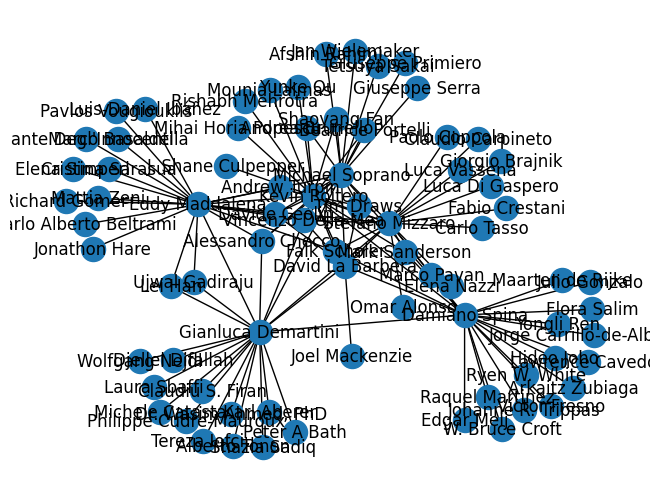

In [4]:
grafo = nx.Graph()

for nome in nodes['name']: 
    grafo.add_node(nome)

for index, row in edges.iterrows():
    grafo.add_edge(row['author1'], row['author2'])
     
nx.draw(grafo, with_labels=True)
plt.show()

nx.write_gml(grafo,"graphs/coauthorship_graph.gml")

### Punto 3b)
Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le seguenti colorazioni: 
+ grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10; 
+ viola per nodi con grado compreso tra 11 e 20;
+ giallo per nodi con grado maggiore di 20. <br>

Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations

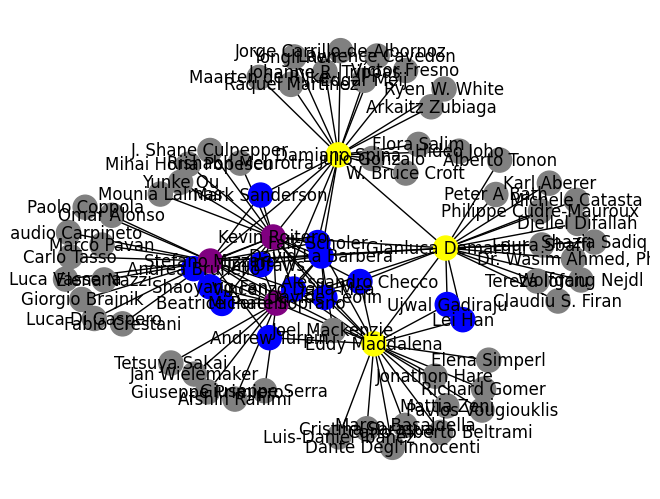

<Figure size 640x480 with 0 Axes>

In [5]:

node_colors = []
for node, degree in grafo.degree():
    if degree == 1:
        node_colors.append('gray')
    elif 2 <= degree <= 10:
        node_colors.append('blue')
    elif 11 <= degree <= 20:
        node_colors.append('purple')
    else:
        node_colors.append('yellow')

# Disegna il grafo con i nodi colorari
nx.draw(
    grafo, 
    with_labels=True, 
    pos = nx.spring_layout(grafo),
    node_color=node_colors)

# Mostra il grafo
plt.show()

# Salvo il graf come pdf
plt.savefig('visualizations/graph.pdf', format='pdf')

### Punto 4)
A partire dal grafo prodotto al punto 3:
+ Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.<br>
Salvare il grafo in locale nella cartella /graphs.
+ Visualizzare e salvare il nuovo grafo come fatto al punto 3b.


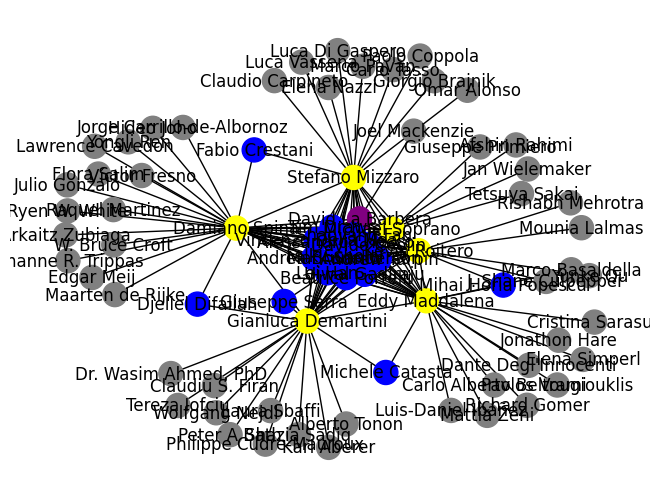

<Figure size 640x480 with 0 Axes>

In [6]:

# Create a copy of the original graph
grafo_preferential_attachment = grafo.copy()
# Numero di archi da aggiungere
new_edges = 50

# Preferential Attachment: probabilità di connessione proporzionale al grado del nodo
degrees = dict(grafo_preferential_attachment.degree())
existing_nodes = list(grafo_preferential_attachment.nodes)

for _ in range(new_edges):
    # Scelta casuale di un nodo esistente proporzionale al suo grado
    nodo_origine = random.choices(existing_nodes, weights=[degrees[n] for n in existing_nodes])[0]

    # Trova un nodo destinazione che non sia già collegato al nodo origine
    nodi_destinazione = set(existing_nodes) - set(grafo_preferential_attachment.neighbors(nodo_origine))
    if nodi_destinazione:
        nuovo_nodo_destinazione = random.choice(list(nodi_destinazione))

        # Aggiungi un arco tra il nodo origine e il nuovo nodo destinazione
        grafo_preferential_attachment.add_edge(nodo_origine, nuovo_nodo_destinazione)
        # Aggiorna il grado dei nodi
        gradi[nodo_origine] += 1
        gradi[nuovo_nodo_destinazione] += 1

# Calculate the degrees for the new graph
node_colors = []
for node, degree in grafo_preferential_attachment.degree():
    if degree == 1:
        node_colors.append('gray')
    elif 2 <= degree <= 10:
        node_colors.append('blue')
    elif 11 <= degree <= 20:
        node_colors.append('purple')
    else:
        node_colors.append('yellow')

# Draw and display the new graph
nx.draw(
    grafo_preferential_attachment, 
    with_labels=True, 
    pos=nx.spring_layout(grafo_preferential_attachment),
    node_color=node_colors)
plt.show()

# Save the new graph as a GML file
nx.write_gml(grafo_preferential_attachment, "graphs/extended_coauthorship_graph.gml")

# Save the visualization of the new graph as a PDF file
plt.savefig('visualizations/extended_graph.pdf', format='pdf')
plt.savefig('visualizations/extended_graph.pdf', format='pdf')

### Punto 5)
Per entrambi i grafi prodotti calcolare:
+ Coefficiente di clustering medio
+ Centro del grafo
+ Raggio
+ Distanza Media
+ Transitività
+ Coefficienti Omega e Sigma, per stimare la “small-world-ness”

Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le informazioni relative ad un grafo, ed ogni colonna le informazioni relative ad una misura calcolata per quel grafo. Salvare nella cartella /results tale DataFrame.


In [7]:
# Calcolo delle metriche per il grafo
clustering_coeff_grafo = nx.average_clustering(grafo)
center_grafo = nx.center(grafo)
radius_grafo = nx.radius(grafo)
medium_distance_grafo = nx.average_shortest_path_length(grafo)
transitivity_grafo = nx.transitivity(grafo)
omega_grafo = nx.omega(grafo)
sigma_grafo = nx.sigma(grafo)

In [8]:
# Calcolo delle metriche per il grafo esteso
clustering_coeff_grafo_pa = nx.average_clustering(grafo_preferential_attachment)
center_grafo_pa = nx.center(grafo_preferential_attachment)
radius_grafo_pa = nx.radius(grafo_preferential_attachment)
medium_distance_grafo_pa = nx.average_shortest_path_length(grafo_preferential_attachment)
transitivity_grafo_pa = nx.transitivity(grafo_preferential_attachment)
omega_grafo_pa = nx.omega(grafo_preferential_attachment)
sigma_grafo_pa = nx.sigma(grafo_preferential_attachment)

In [10]:
info_graphs = pd.DataFrame(columns=['average clustering coefficient', 'center', 'radius', 'medium distance', 'transitivity', 'omega', 'sigma'])

# Dataframe 
info_graphs.loc[0] = {'average clustering coefficient': clustering_coeff_grafo, 
                      'center': center_grafo, 
                      'radius': radius_grafo, 
                      'medium distance': medium_distance_grafo, 
                      'transitivity': transitivity_grafo, 

                      'omega': omega_grafo, 
                      'sigma': sigma_grafo
                     }

info_graphs.loc[1] = {'average clustering coefficient': clustering_coeff_grafo_pa, 
                      'center': center_grafo_pa, 
                      'radius': radius_grafo_pa, 
                      'medium distance': medium_distance_grafo_pa, 

                      'transitivity': transitivity_grafo_pa, 
                      'omega': omega_grafo_pa, 
                      'sigma': sigma_grafo_pa
                     }

display(info_graphs)

# Percorso del file in cui salvare il DataFrame
results_file_path = 'results/graph_metrics.csv'

# Salvataggio del DataFrame in un file CSV nella cartella /results
info_graphs.to_csv(results_file_path, index=False)


,average clustering coefficient,center,radius,medium distance,transitivity,omega,sigma
0,0.250505,"[Alessandro Checco, Damiano Spina, David La Ba...",2,2.390175,0.290469,0.002110,0.999442
1,0.250505,"[Alessandro Checco, Damiano Spina, David La Ba...",2,2.390175,0.290469,0.002156,0.999207


### Punto 6)
Per entrambi i grafi prodotti calcolare per ogni nodo:
+ Degree Centrality
+ Betweenness Centrality
+ Closeness Centrality
+ Pagerank
+ HITS, per calcolare i valori di hubness e authority

Riassumere le due informazioni in un DataFrame per ciascun grafo, dove
ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le
informazioni relative ad una misura calcolata per quel nodo. Salvare nella
cartella /results tali DataFrame

In [14]:
def calculate_metrics(graph):
    # Calcolo delle metriche
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    pagerank = nx.pagerank(graph)
    hubs, authorities = nx.hits(graph)

    # Creazione di un DataFrame per riassumere le metriche
    metrics_df = pd.DataFrame({
        'Degree Centrality': degree_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Closeness Centrality': closeness_centrality,
        'Pagerank': pagerank,
        'Hubs': hubs,
        'Authorities': authorities
    })

    return metrics_df

# Calcolo delle metriche per il grafo originale e quello con preferential attachment
metrics_grafo = calculate_metrics(grafo)
metrics_grafo_pa = calculate_metrics(grafo_preferential_attachment)

# Salvataggio dei DataFrame nelle cartelle /results
metrics_grafo.to_csv('results/metrics_grafo.csv', index=False)
metrics_grafo_pa.to_csv('results/metrics_grafo_pa.csv', index=False)

### Punto 7)
Produrre una visualizzazione interattiva con PyVis dei due grafi con colorazioni di
nodi ed archi a piacimento. Salvare i due output in formato HTML nella cartella
/visualizations .


In [18]:
def save_graph_html(graph, file_name):
    net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

    # Calcola il grado di ogni nodo
    degrees = dict(graph.degree())

    # Trova il grado massimo per normalizzare le dimensioni dei nodi
    max_degree = max(degrees.values())

    # Aggiunta dei nodi con personalizzazione
    for node in graph.nodes():
        # Assicura che anche i nodi con un grado basso abbiano una dimensione visibile
        # Ad esempio, dimensione base di 10 + scala in base al grado
        size = 10 + (degrees[node] / max_degree) * 15  

        title = f"Grado: {degrees[node]}"  # Tooltip per il nodo
        color = "#f0a30a" if node in set(nx.center(graph)) else "#7B68EE" # Colore in base alla centralità

        net.add_node(node, title=title, size=size, color=color)

    # Aggiunta degli archi
    for source, target in graph.edges():
        net.add_edge(source, target)

    # Impostazioni della fisica del grafo
    net.toggle_physics(True)
    net.set_options("""
    var options = {
      "physics": {
        "barnesHut": {
          "springLength": 200
        },
        "minVelocity": 0.75
      }
    }
    """)

    # Salvataggio del grafo in HTML
    net.save_graph(f'visualizations/{file_name}')

# Personalizzazione e salvataggio delle visualizzazioni per entrambi i grafi
save_graph_html(grafo, 'grafo.html')
save_graph_html(grafo_preferential_attachment, 'grafo_pa.html')